# **STATCORE**

## Anggota Team


1.   Nanang Safiu Ridho
2.   Achmad Rivqi
3. Andi Ullia



## Intro

Notebook ini bertujuan untuk mengembangkan model Human Fall Detection melalui analisis frame-frame video yang sudah dibuat dalam format images. Dataset yang digunakan terdiri dari dua kategori utama, yaitu fall (termasuk berbagai tipe jatuh seperti backward falls, forward falls, dan lainnya) dan non_fall (seperti gerakan berjalan, melompat, atau jongkok). Model yang dibangun akan dikembangkan untuk mengklasifikasikan ribuan frame pada dataset uji dengan akurasi tinggi, menggunakan label 0 untuk non_fall dan 1 untuk fall. Proses evaluasi model akan mencakup metrik seperti ROC-AUC, akurasi, precision, dan recall, sehingga hasil akhir dapat memberikan solusi yang andal untuk mendeteksi kejadian jatuh secara otomatis.

# ***Import Library dan Setup***


## Import Library


Pada bagian ini, semua library yang diperlukan untuk pengembangan model akan diimpor. Library seperti TensorFlow, NumPy, dan Matplotlib digunakan untuk pemrosesan data, pelatihan model, dan visualisasi hasil.

In [10]:
from google.colab import drive
import os
import random
import numpy as np
from glob import glob
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import AdamW, SGD, schedules
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tqdm import tqdm

## Mounting Google Drive

Langkah ini dilakukan untuk mengakses dataset yang tersimpan di Google Drive. Dengan melakukan mounting, file-file yang dibutuhkan dapat dihubungkan langsung ke lingkungan notebook untuk mendukung proses analisis dan pengembangan model.

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## Definisi Direktori di Google Drive

In [4]:
train_dir = '/content/drive/MyDrive/data-slayer-2-0-machine-learning-competition/train'
test_dir = '/content/drive/MyDrive/data-slayer-2-0-machine-learning-competition/test'

# ***Data Preparation***

Pada tahap ini kami membangun syntax yang mencakup fungsi untuk memuat data dari direktori gambar beserta labelnya, kemudian membuat DataFrame menggunakan pandas untuk mempermudah pengelolaan data

## Memuat Dataset

In [5]:
# Fungsi Untuk Memuat Data
def get_image_labels(base_dir):
    image_paths = []
    labels = []
    for subject in os.listdir(base_dir):
        subject_dir = os.path.join(base_dir, subject)
        for action_type in ['fall', 'non_fall']:
            action_dir = os.path.join(subject_dir, action_type)
            if os.path.isdir(action_dir):
                for action in os.listdir(action_dir):
                    action_subdir = os.path.join(action_dir, action)
                    if os.path.isdir(action_subdir):
                        for img_name in os.listdir(action_subdir):
                            if img_name.endswith(('.jpg', '.png')):
                                image_paths.append(os.path.join(action_subdir, img_name))
                                labels.append(1 if action_type == 'fall' else 0)
    return image_paths, labels

# Memuat Data
image_paths, labels = get_image_labels(train_dir)

## Membuat DataFrame

In [6]:
# Membuat DataFrame dengan informasi gambar dan label
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})
print(df.head(10))

                                          image_path  label
0  /content/drive/MyDrive/data-slayer-2-0-machine...      1
1  /content/drive/MyDrive/data-slayer-2-0-machine...      1
2  /content/drive/MyDrive/data-slayer-2-0-machine...      1
3  /content/drive/MyDrive/data-slayer-2-0-machine...      1
4  /content/drive/MyDrive/data-slayer-2-0-machine...      1
5  /content/drive/MyDrive/data-slayer-2-0-machine...      1
6  /content/drive/MyDrive/data-slayer-2-0-machine...      1
7  /content/drive/MyDrive/data-slayer-2-0-machine...      1
8  /content/drive/MyDrive/data-slayer-2-0-machine...      1
9  /content/drive/MyDrive/data-slayer-2-0-machine...      1


# ***Exploratory Data Analysis (EDA)***

Untuk memahami data secara mendalam, langkah pertama adalah menganalisis distribusi label dalam dataset. Distribusi label ini penting untuk memastikan apakah data seimbang antara kategori fall dan non_fall, sehingga model yang dibangun tidak bias terhadap salah satu kategori. Selain itu, beberapa contoh gambar dari dataset akan ditampilkan bersama labelnya untuk memberikan gambaran visual mengenai data yang akan digunakan. Langkah ini membantu dalam memvalidasi bahwa data telah dimuat dengan benar sesuai struktur yang diharapkan.

## Menampilkan Distribusi Data

Distribusi data awal:


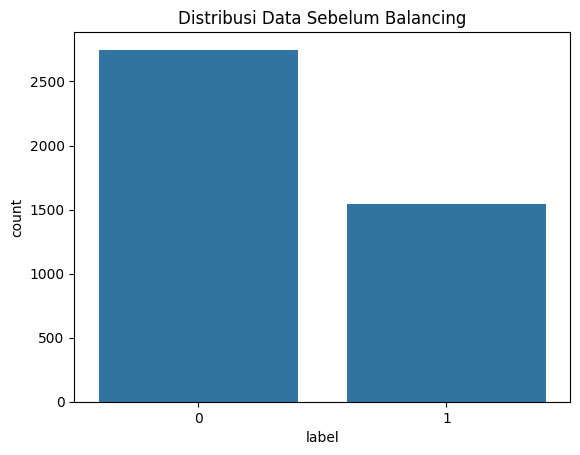

In [7]:
print("Distribusi data awal:")
sns.countplot(x='label', data=df)
plt.title("Distribusi Data Sebelum Balancing")
plt.show()

Terlihat jelas dari visualisasi yang diberikan bahwa label non_fall lebih dominasi dari pada label fall

## Menampilkan Beberapa Contoh Gambar dan Label


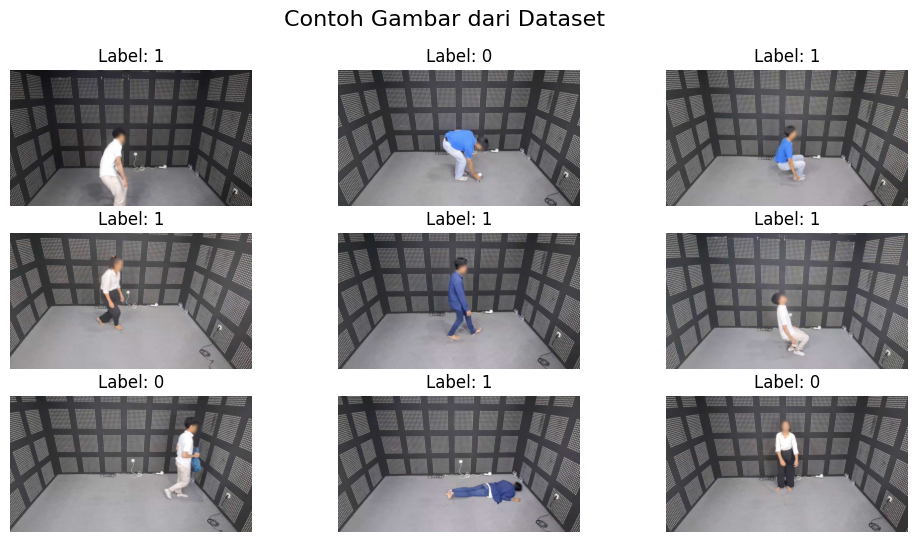

In [11]:
plt.figure(figsize=(12, 6))

# Mengambil indeks acak sebanyak 9 gambar
random_indices = random.sample(range(len(image_paths)), 9)
sample_images = [image_paths[i] for i in random_indices]
sample_labels = [labels[i] for i in random_indices]

for i in range(9):
    img = plt.imread(sample_images[i])
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {sample_labels[i]}")
    plt.axis("off")

plt.suptitle("Contoh Gambar dari Dataset", fontsize=16)
plt.show()

# ***Data Preprocessing***

## Hitung class weights


Pendekatan ini dirancang untuk menangani ketidakseimbangan kelas dalam dataset dan mempersiapkan data untuk pelatihan model. Penghitungan class weights dilakukan menggunakan fungsi compute_class_weight dari sklearn.utils.class_weight, yang memastikan bahwa model memberikan perhatian yang proporsional pada kelas minoritas, sehingga mengurangi potensi bias terhadap kelas mayoritas.

In [12]:
label = df['label']
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label),
    y=label
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights)

Class Weights: {0: 0.7812954876273653, 1: 1.388745148771022}


Dengan Penetapan class_weight ini diharapkan masalah ketidak seimbangan kelas bisa ditangani.

## Augmentasi Data, Normalisasi Data, dan Pembagian Train dan Validation.



Selanjutnya, dilakukan augmentasi data menggunakan ImageDataGenerator untuk meningkatkan keragaman data latih secara virtual. Parameter seperti rotasi, pergeseran, zoom, dan flip digunakan untuk mensimulasikan variasi dalam data nyata, meningkatkan kemampuan generalisasi model. Augmentasi ini diterapkan pada data pelatihan, sementara data validasi hanya dinormalisasi dengan rescale=1./255 untuk menjaga integritas evaluasi.

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.25
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25
)

Label pada dataset dikonversi menjadi string agar kompatibel dengan parameter class_mode="binary" dalam generator. DataFrame kemudian digunakan untuk membuat generator train_generator dan validation_generator, di mana subset pelatihan dan validasi dipisahkan menggunakan validation_split. Dengan ukuran target (224, 224) dan batch_size=64, generator ini memastikan data disajikan dalam format yang sesuai untuk model deep learning. Pendekatan ini tidak hanya menangani data ketidakseimbangan tetapi juga memaksimalkan potensi pelatihan melalui augmentasi yang terukur.

In [14]:
# Konversi label ke string agar kompatibel dengan class_mode="binary"
df['label'] = df['label'].astype(str)

# Generator untuk train dan validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 3221 validated image filenames belonging to 2 classes.
Found 1073 validated image filenames belonging to 2 classes.


# ***Model Baseline: Transfer Learning dengan MobileNetV2***

## Arsitektur Model


Model menggunakan MobileNetV2 sebagai base model dengan bobot pra-latih imagenet untuk memanfaatkan fitur-fitur yang sudah terlatih. Base model ini dibekukan (trainable=False) untuk mempertahankan kemampuan ekstraksi fiturnya. Selanjutnya, ditambahkan lapisan Global Average Pooling, Dense layer dengan Regularisasi L2 untuk mencegah overfitting, serta Dropout untuk meningkatkan generalisasi.

In [15]:
# Load MobileNetV2 sebagai base model
input_tensor = Input(shape=(224, 224, 3))
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)

<ipython-input-15-fdd34485d154>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [16]:
# Freeze base model
base_model.trainable = False

In [17]:
# Global Average Pooling dan penambahan Dropout dan L2 Regularization
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [18]:
# Final model
model = Model(inputs=input_tensor, outputs=x)

## Hyperparameter Tuning

Hyperparameter seperti learning rate diatur menggunakan Exponential Decay, yang secara bertahap mengurangi nilai learning rate selama pelatihan. Pendekatan ini membantu model beradaptasi secara stabil tanpa kehilangan performa pada langkah-langkah akhir pelatihan.

In [19]:
# Hyperparameter Tuning: Gunakan Learning Rate Scheduling
initial_learning_rate = 1e-3

In [20]:
lr_schedule = schedules.ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)

## Compile dan Callbacks

Model di-compile dengan optimizer AdamW, menggunakan loss binary_crossentropy, dan metrik akurasi. Callbacks seperti EarlyStopping diterapkan untuk menghentikan pelatihan jika performa validasi memburuk, sementara ReduceLROnPlateau menyesuaikan learning rate secara dinamis. Model terbaik disimpan dengan ModelCheckpoint untuk digunakan pada evaluasi lebih lanjut.

In [21]:
# Compile model
model.compile(optimizer=AdamW(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model_save_path = '/content/drive/MyDrive/best_model.keras'
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True)

# ***Model Training***

## Fungsi Untuk Visualisasi Hasil Training


Untuk mengevaluasi performa model selama pelatihan, grafik akurasi dan loss per epoch digunakan. Fungsi plot_history() dirancang untuk menampilkan tren akurasi dan loss pada data pelatihan dan validasi. Grafik ini mempermudah identifikasi pola overfitting atau underfitting sehingga strategi pelatihan dapat disesuaikan, seperti menambah epoch atau melakukan data augmentasi lebih lanjut.

In [22]:
def plot_history(history):

    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

    ax[0].set_title('Training Accuracy vs. Epochs')
    ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
    ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='best')

    ax[1].set_title('Training/Validation Loss vs. Epochs')
    ax[1].plot(train_loss, 'o-', label='Train Loss')
    ax[1].plot(val_loss, 'o-', label='Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='best')

    plt.tight_layout()
    plt.show()

## Pelatihan Model

Proses pelatihan menggunakan metode model.fit() dengan distribusi class weights untuk menangani ketidakseimbangan data, sehingga model tidak bias terhadap kelas tertentu. Selain itu, callbacks seperti EarlyStopping digunakan untuk menghentikan pelatihan lebih awal jika performa validasi memburuk, sementara ReduceLROnPlateau menyesuaikan learning rate untuk stabilitas pelatihan. Checkpoint diterapkan untuk menyimpan model terbaik berdasarkan performa validasi.

In [23]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


202/202 ━━━━━━━━━━━━━━━━━━━━ 2931s 14s/step - accuracy: 0.7168 - loss: 4.4339 - val_accuracy: 0.7260 - val_loss: 3.4609 - learning_rate: 1.0000e-04
Epoch 2/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 114s 379ms/step - accuracy: 0.8465 - loss: 3.0875 - val_accuracy: 0.7661 - val_loss: 2.6348 - learning_rate: 1.0000e-04
Epoch 3/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 83s 383ms/step - accuracy: 0.8848 - loss: 2.3332 - val_accuracy: 0.8136 - val_loss: 2.1080 - learning_rate: 1.0000e-04
Epoch 4/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 77s 372ms/step - accuracy: 0.8714 - loss: 1.8986 - val_accuracy: 0.8341 - val_loss: 1.7637 - learning_rate: 1.0000e-04
Epoch 5/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 79s 381ms/step - accuracy: 0.8902 - loss: 1.5658 - val_accuracy: 0.8201 - val_loss: 1.5492 - learning_rate: 1.0000e-04
Epoch 6/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 80s 370ms/step - accuracy: 0.8934 - loss: 1.3422 - val_accuracy: 0.8388 - val_loss: 1.3520 - learning_rate: 1.0000e-04
Epoch 7/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 82s 370ms/step -

## Visualisasi hasil training


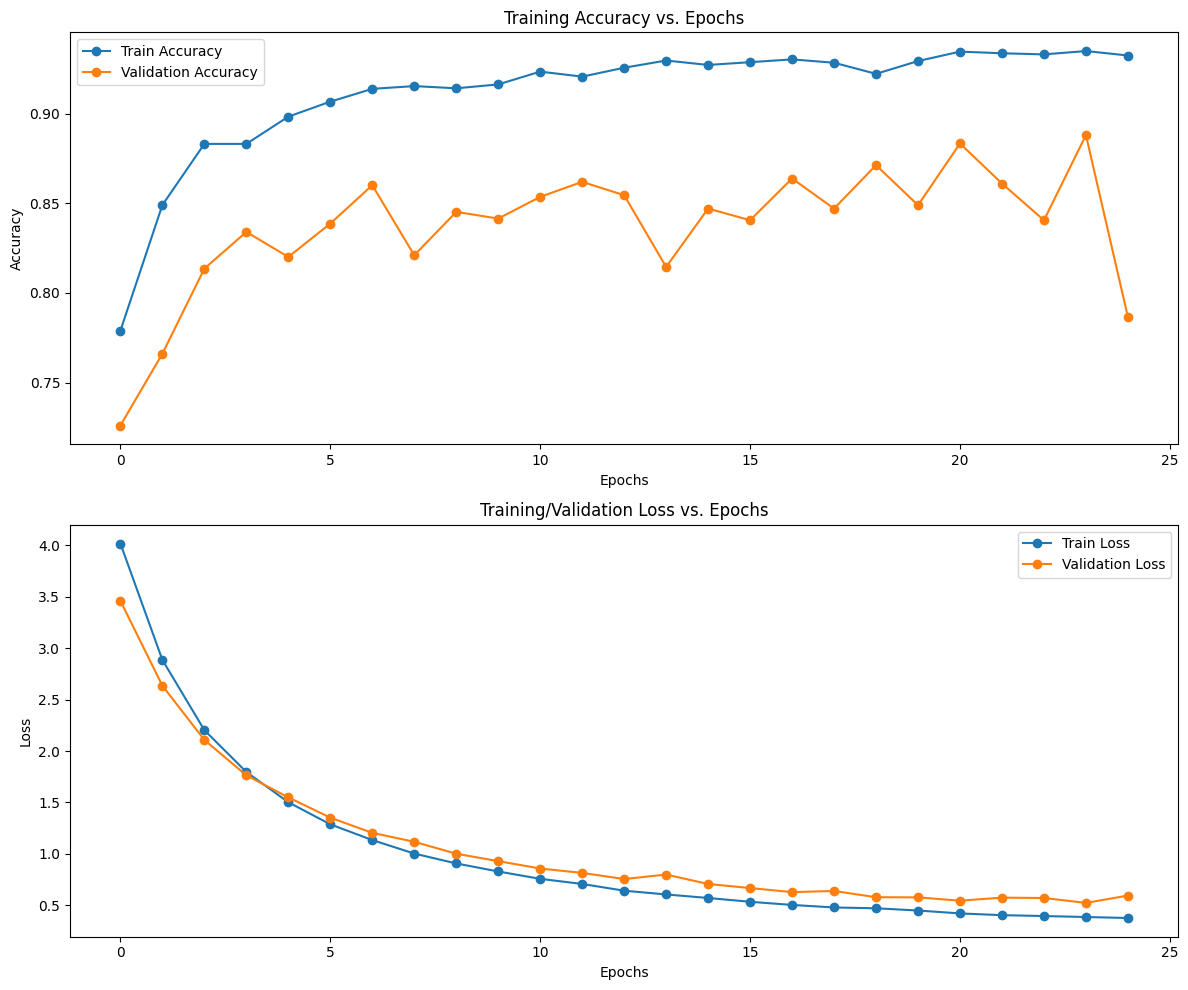

In [24]:
plot_history(history)

Grafik menunjukkan bahwa akurasi pelatihan terus meningkat, sedangkan akurasi validasi berfluktuasi setelah mencapai puncaknya, mengindikasikan kemungkinan overfitting. Selain itu, loss pelatihan dan validasi menurun konsisten tetapi mulai menunjukkan perbedaan di akhir, memperkuat indikasi overfitting. Perbaikan dapat dilakukan dengan menambahkan regularisasi.

# ***Model Evaluation***

## Fungsi Untuk Evaluasi Model


Setelah pelatihan selesai, fungsi evaluate() digunakan untuk analisis mendalam terhadap performa model. Evaluasi mencakup Confusion Matrix, laporan klasifikasi, serta skor ROC-AUC untuk mengukur kemampuan model membedakan kelas. Selain itu, grafik ROC memberikan visualisasi performa prediksi. Pendekatan ini memastikan bahwa hasil evaluasi komprehensif, membantu memahami kekuatan dan kelemahan model dalam mendeteksi kejadian jatuh.

In [25]:
def evaluate(model, history, val_generator):

    # Plot akurasi dan loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

    # Evaluasi confusion matrix
    val_labels = val_generator.classes
    val_preds = (model.predict(val_generator) > 0.5).astype('int32').flatten()

    cm = confusion_matrix(val_labels, val_preds)
    print("Confusion Matrix:")
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Fall', 'Fall'], yticklabels=['Non Fall', 'Fall'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Classification report
    print("Classification Report:")
    print(classification_report(val_labels, val_preds, target_names=['Non Fall', 'Fall']))

    # ROC-AUC
    roc_auc = roc_auc_score(val_labels, val_preds)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    RocCurveDisplay.from_predictions(val_labels, val_preds)
    plt.show()

## Evalusi Model

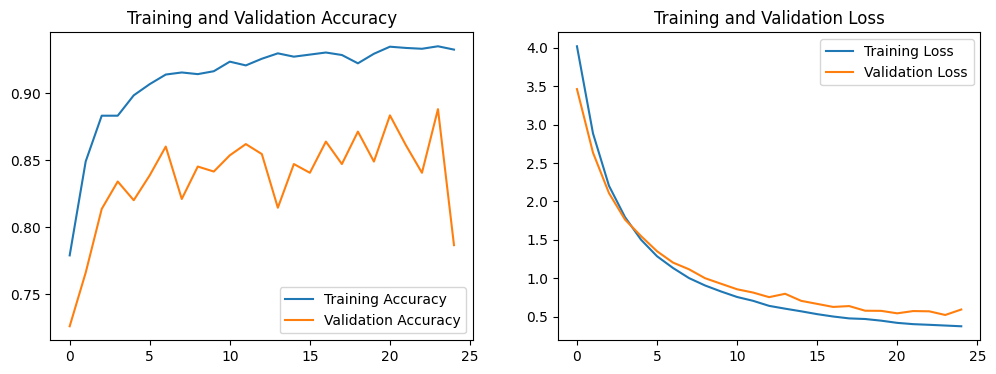

68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step
Confusion Matrix:


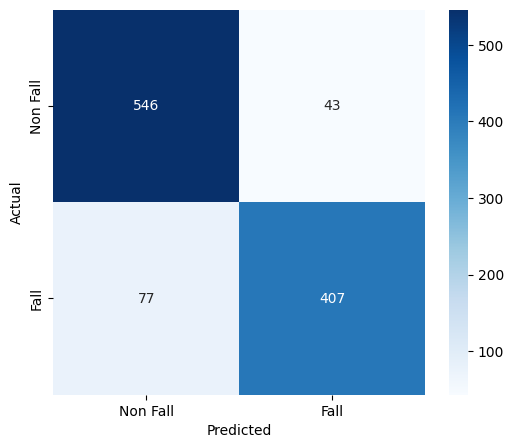

Classification Report:
              precision    recall  f1-score   support

    Non Fall       0.88      0.93      0.90       589
        Fall       0.90      0.84      0.87       484

    accuracy                           0.89      1073
   macro avg       0.89      0.88      0.89      1073
weighted avg       0.89      0.89      0.89      1073

ROC-AUC Score: 0.8840


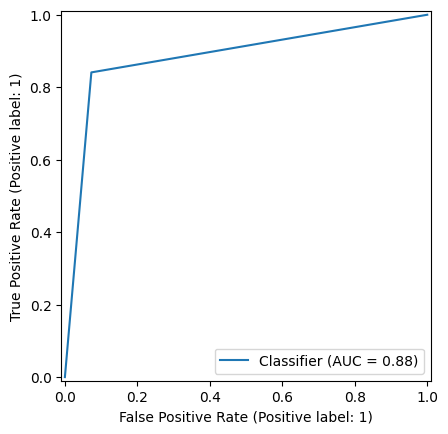

In [26]:
# Panggil fungsi evaluasi
evaluate(model, history, validation_generator)

Model memiliki performa yang cukup baik dengan akurasi keseluruhan sebesar 89%.

1. Confusion Matrix: Model berhasil mengklasifikasikan 546 Non Fall dan 407 Fall dengan benar. Namun, terjadi 43 kesalahan pada Non Fall yang diklasifikasikan sebagai Fall, dan 77 kesalahan pada Fall yang diklasifikasikan sebagai Non Fall.

2. Classification Report: Non Fall: Precision 88%, recall 93%, dan f1-score 90%.
Fall: Precision 90%, recall 84%, dan f1-score 87%.
F1-score menunjukkan keseimbangan antara presisi dan recall, dengan nilai yang lebih tinggi untuk Non Fall dibandingkan Fall.

3. ROC-AUC Score: Skor 0.884 menunjukkan model memiliki kemampuan klasifikasi yang cukup baik secara keseluruhan.

Namun, model sedikit lebih baik dalam mendeteksi Non Fall dibandingkan Fall, sehingga perlu dilakukan penyesuaian untuk mengurangi kesalahan deteksi pada kelas Fall.

# ***Fine-Tuning***

Pada tahap fine-tuning, beberapa lapisan terakhir dari model base MobileNetV2 di-unfreeze untuk memungkinkan pembelajaran fitur yang lebih spesifik pada dataset yang digunakan. Dengan hanya membuka pelatihan pada 50 lapisan terakhir, risiko overfitting dapat diminimalkan karena sebagian besar parameter dasar tetap beku, mempertahankan keunggulan transfer learning. Model kemudian di-recompile menggunakan optimizer SGD dengan learning rate kecil dan momentum untuk memastikan pembaruan parameter dilakukan secara stabil.

## Pembukaan Layer Model

In [27]:
# Unfreeze beberapa layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

## Recompile

In [28]:
# Recompile model untuk fine-tuning
model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

## Pelatihan Ulang

Pelatihan dilanjutkan dengan konfigurasi yang sama seperti sebelumnya, termasuk penggunaan callbacks untuk mengontrol durasi pelatihan dan menghindari overfitting. Hasil dari fine-tuning divisualisasikan melalui grafik akurasi dan loss menggunakan fungsi plot_history(), serta evaluasi lebih lanjut dilakukan dengan fungsi evaluate() untuk mengukur metrik performa seperti Confusion Matrix, laporan klasifikasi, dan skor ROC-AUC. Pendekatan ini memastikan bahwa fine-tuning memberikan kontribusi positif terhadap performa model tanpa mengorbankan stabilitas pelatihan.

In [29]:
# Lanjutkan training untuk fine-tuning
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 107s 438ms/step - accuracy: 0.8442 - loss: 0.5441 - val_accuracy: 0.8779 - val_loss: 0.5367 - learning_rate: 1.0000e-04
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 126s 404ms/step - accuracy: 0.9234 - loss: 0.3978 - val_accuracy: 0.8127 - val_loss: 0.6347 - learning_rate: 1.0000e-04
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 78s 376ms/step - accuracy: 0.9416 - loss: 0.3528 - val_accuracy: 0.8490 - val_loss: 0.5593 - learning_rate: 1.0000e-04
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 94s 436ms/step - accuracy: 0.9596 - loss: 0.3110 - val_accuracy: 0.8322 - val_loss: 0.5904 - learning_rate: 1.0000e-04
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 135s 398ms/step - accuracy: 0.9548 - loss: 0.3113 - val_accuracy: 0.8425 - val_loss: 0.5793 - learning_rate: 5.0000e-05


## Visualisasi Hasil Fine-Tuning

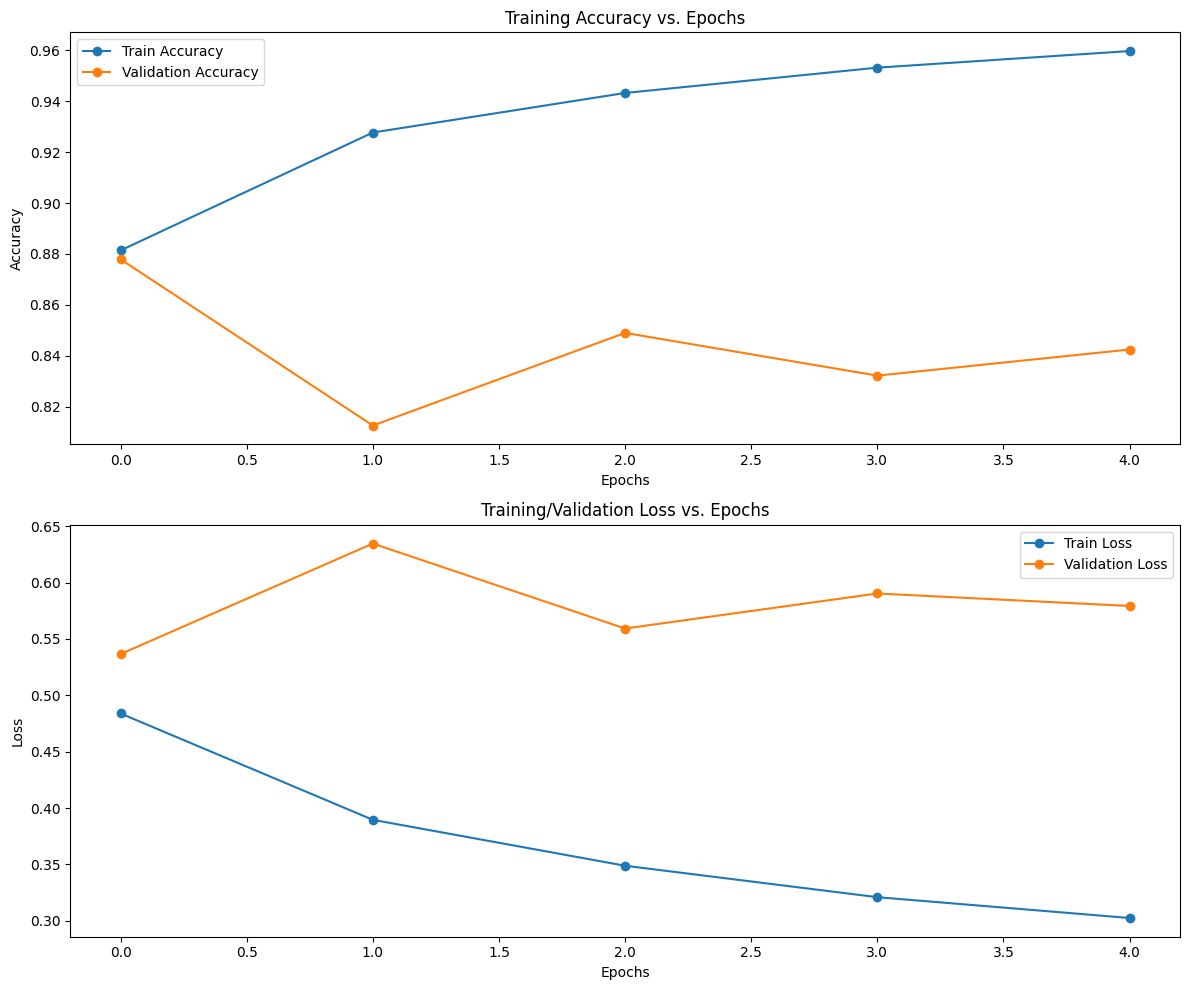

In [30]:
plot_history(history_fine)

Grafik menunjukkan bahwa akurasi pelatihan meningkat secara konsisten seiring bertambahnya epoch, sedangkan akurasi validasi mengalami fluktuasi, dengan penurunan signifikan di awal sebelum stabil kembali. Hal ini menunjukkan potensi underfitting di awal dan indikasi bahwa model belum sepenuhnya menggeneralisasi dengan baik pada data validasi.

## Evaluasi Hasil Fine-Tuning

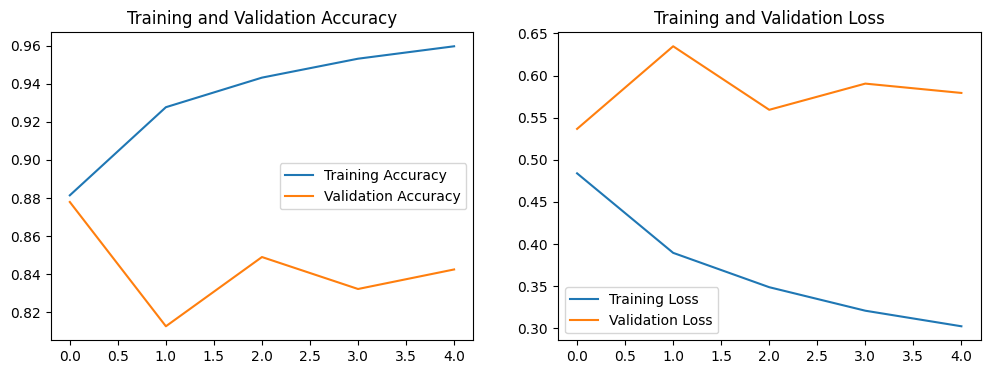

68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step
Confusion Matrix:


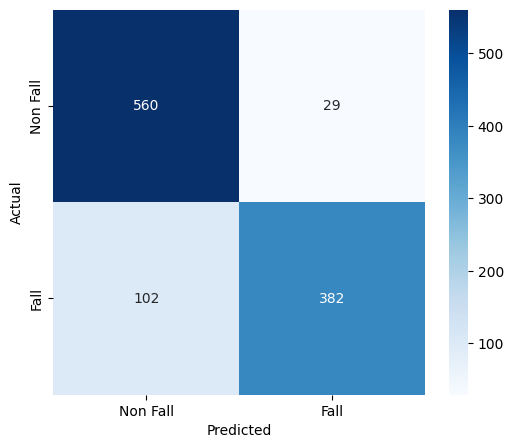

Classification Report:
              precision    recall  f1-score   support

    Non Fall       0.85      0.95      0.90       589
        Fall       0.93      0.79      0.85       484

    accuracy                           0.88      1073
   macro avg       0.89      0.87      0.87      1073
weighted avg       0.88      0.88      0.88      1073

ROC-AUC Score: 0.8700


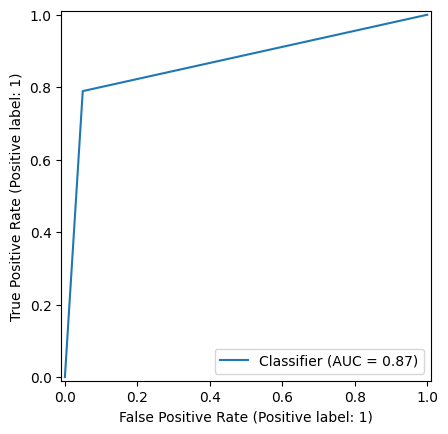

In [31]:
evaluate(model, history_fine, validation_generator)

Model memiliki akurasi keseluruhan sebesar 88%, dengan detail sebagai berikut:

1. Confusion Matrix: Model berhasil mengklasifikasikan 560 Non Fall dan 382 Fall dengan benar. Namun, terdapat 29 kesalahan pada Non Fall yang diklasifikasikan sebagai Fall, dan 102 kesalahan pada Fall yang diklasifikasikan sebagai Non Fall.

2. Classification Report: Non Fall: Precision 85%, recall 95%, dan f1-score 90%.
Fall: Precision 93%, recall 79%, dan f1-score 85%.
Model lebih baik dalam mendeteksi Non Fall dibandingkan Fall, terlihat dari recall yang lebih tinggi pada Non Fall.

3. ROC-AUC Score: Skor 0.870 menunjukkan kemampuan klasifikasi model cukup baik, tetapi ada ruang untuk perbaikan terutama dalam mendeteksi kelas Fall.

Perbaikan dapat dilakukan dengan menyeimbangkan data atau memberikan perhatian lebih pada kelas Fall untuk mengurangi kesalahan klasifikasi.

# ***Testing and Prediction***

Fungsi predict_image dirancang untuk memproses gambar uji satu per satu, mengubahnya ke format yang sesuai dengan model, dan menghasilkan prediksi berbasis ambang batas (default 0.5). Daftar nama file gambar di folder uji dibaca secara iteratif, kemudian setiap gambar diprediksi menggunakan model yang telah dilatih. Hasil prediksi berupa pasangan id gambar dan label prediksi (0 atau 1), yang kemudian disimpan dalam daftar submission. Pendekatan ini memastikan proses prediksi berjalan efisien dan dapat dengan mudah diintegrasikan ke dalam pembuatan file submission.

## Fungsi Untuk Memproses Data Test dan Melakukan Prediksi


In [32]:
def predict_image(img_path, model, threshold=0.5):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array, verbose=0)
    return pred[0][0] > threshold

## Mempersiapkan Data Test dan Melakukan Prediksi

In [33]:
submission = []
test_images = [img_file for img_file in os.listdir(test_dir) if img_file.endswith(('.jpg', '.png'))]

for img_file in tqdm(test_images, desc="Predicting Test Images"):
    img_path = os.path.join(test_dir, img_file)
    pred = predict_image(img_path, model, threshold=0.5)
    submission.append({'id': img_file, 'label': int(pred)})

Predicting Test Images: 100%|██████████| 2152/2152 [03:59<00:00,  8.97it/s]


# ***Submission***

Hasil prediksi disimpan dalam file CSV menggunakan pd.DataFrame dan to_csv untuk mempermudah pengiriman file submission. File disimpan dengan nama yang sesuai ke direktori Google Drive untuk aksesibilitas. Selanjutnya, fungsi show_predictions digunakan untuk memvisualisasikan beberapa prediksi secara acak dari dataset uji. Fungsi ini menampilkan gambar beserta label prediksi yang menunjukkan apakah gambar tersebut diklasifikasikan sebagai Fall atau Non-Fall. Visualisasi ini membantu memvalidasi hasil prediksi secara intuitif, memberikan gambaran kinerja model secara langsung pada data uji. Strategi ini penting untuk memastikan file submission dan hasil prediksi selaras dengan ekspektasi.

## Simpan Hasil Prediksi ke CSV


In [34]:
submission_df = pd.DataFrame(submission)
submission_df.to_csv('/content/drive/MyDrive/submissionstatcore.csv', index=False)
print("Submission CSV saved!")

submission_df.head(200)

Submission CSV saved!


,id,label
0,852d79ceeb.jpg,0
1,8712749852.jpg,0
2,8500335440.jpg,0
3,889596ec56.jpg,0
4,88bdaa1a32.jpg,0
...,...,...
195,9dc88ff28b.jpg,0
196,9c23e82777.jpg,1
197,9d8f8c0957.jpg,0
198,9d87b466ac.jpg,0


## Menyimpan Model

In [35]:
model_save_path_drive = '/content/drive/MyDrive/final_model.keras'
model.save(model_save_path_drive)
print(f"Model disimpan di Google Drive pada {model_save_path_drive}")

Model disimpan di Google Drive pada /content/drive/MyDrive/final_model.keras


## Menampilkan Beberapa Hasil Prediksi

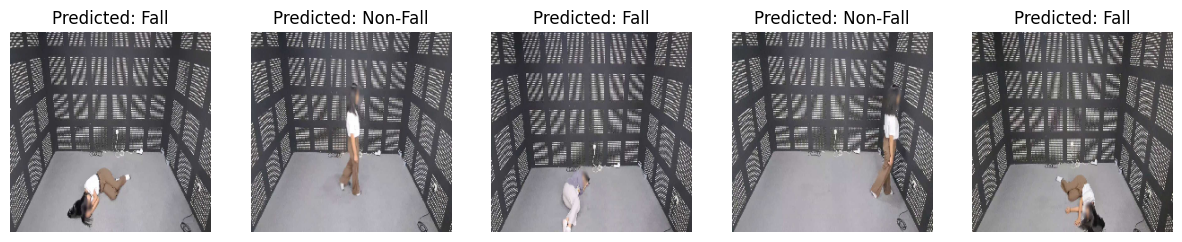

In [38]:
def show_predictions(test_dir, submission_df, num_images=5):
    plt.figure(figsize=(15, 15))

    # Ambil contoh gambar secara acak
    sample_predictions = submission_df.sample(n=num_images).reset_index(drop=True)

    for i, row in sample_predictions.iterrows():
        img_path = os.path.join(test_dir, row['id'])
        img = load_img(img_path, target_size=(224, 224))

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Predicted: {'Fall' if row['label'] == 1 else 'Non-Fall'}")
        plt.axis('off')

    plt.show()

# Panggil fungsi untuk menampilkan prediksi
show_predictions(test_dir, submission_df, num_images=5)

Dapat dilihat pada beberapa contoh hasil prediksi yang di tampilkan, prediksi yang didapat sudah tepat sesuai kejadian pada image.

# ***Kesimpulan***

Model Human Fall Detection ini telah dikembangkan dengan berbagai langkah, mulai dari persiapan data hingga evaluasi hasil. Dengan menggunakan MobileNetV2 sebagai dasar model, kami berhasil mencapai akurasi yang baik dalam membedakan antara kejadian fall dan non_fall. Untuk meningkatkan kinerja, kami juga menerapkan teknik seperti penyesuaian bobot kelas dan augmentasi data.

Setelah melatih model, kami menguji hasilnya dan menyimpannya dalam format yang sesuai. Hasil prediksi juga ditampilkan dengan gambar agar lebih mudah dipahami. Secara keseluruhan, model ini efektif dalam mendeteksi kejadian jatuh, memberikan solusi yang bermanfaat dan dapat diandalkan. Sehingg ddengan model ini diharapkan hasil prediksi bisa mencapai accuracy yang baik.